In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint

import pathlib
import cv2
import pandas



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
!ls

drive	    final_vlad	sample_data	test_images  test_roads
final_mask  PM2.5.csv	test_buildings	test_masks   vlad.csv


In [4]:
!unzip -n './drive/MyDrive/models/mearth.zip'
!unzip -n './drive/MyDrive/models/test_set.zip'

Archive:  ./drive/MyDrive/models/mearth.zip
  inflating: final_mask/bacninh_caoduc.png  
  inflating: final_mask/bacninh_cho.png  
  inflating: final_mask/bacninh_suoihoa.png  
  inflating: final_mask/baria.png    
  inflating: final_mask/caobang_detham.png  
  inflating: final_mask/danang.png   
  inflating: final_mask/danang_thachthang.png  
  inflating: final_mask/daocathai.png  
  inflating: final_mask/haiphong.png  
  inflating: final_mask/haiphong_anhdung.png  
  inflating: final_mask/haiphong_cathai.png  
  inflating: final_mask/halong.png   
  inflating: final_mask/hanam_trangan.png  
  inflating: final_mask/hanoi_caugiay.png  
  inflating: final_mask/hanoi_conhue.png  
  inflating: final_mask/hanoi_cuanam.png  
  inflating: final_mask/hanoi_cukhoi.png  
  inflating: final_mask/hanoi_giathuy.png  
  inflating: final_mask/hanoi_lienquan.png  
  inflating: final_mask/hanoi_minhkhai.png  
  inflating: final_mask/hanoi_ngoclam.png  
  inflating: final_mask/hanoi_phumy.png  
  infla

In [6]:
# Parametres
train = pathlib.Path(r'./PM2.5.csv')
valid = pathlib.Path(r'./vlad.csv')
altitude = 2.4

In [7]:
def get_data():
    print('date?')
    dataframe1 = pandas.read_csv(train, delimiter=',', names=["ct", "airq"])
    dataframe2 = pandas.read_csv(valid, delimiter=',', names=["ct", "airq"])
    print(dataframe1)
    print(dataframe2)
    l_train = np.asarray(dataframe1)
    l_valid = np.asarray(dataframe2)
    print(l_train.shape, l_valid.shape)
    x_train, y_train = l_train[:, 0], l_train[:, 1]
    x_valid, y_valid = l_valid[:, 0], l_valid[:, 1]
    y_train = y_train.astype('float32')
    y_valid = y_valid.astype('float32')
    images_train = np.zeros(shape=(len(l_train), 1024, 1024, 3))
    images_valid = np.zeros(shape=(len(l_valid), 1024, 1024, 3))
    for i in range(len(l_train)):
        #print('./final_mask/'+x_train[i]+'.png')
        im = cv2.imread('./final_mask/'+x_train[i]+'.png')
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (1024, 1024), interpolation = cv2.INTER_LANCZOS4)
        im = np.expand_dims(im, axis=0)
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        images_train[i] = np.asarray(im)#.astype('float32')
        #print(images_train[i])
        images_train[i] = images_train[i]/255
        #print(images_train[i])
    for i in range(len(l_valid)):
        im = cv2.imread('./final_vlad/'+x_valid[i]+'.png')
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (1024, 1024), interpolation = cv2.INTER_LANCZOS4)
        im = np.expand_dims(im, axis=0)
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        images_valid[i] = np.asarray(im)#.astype('float32')
        #print(images_valid[i])
        images_valid[i] = images_valid[i]/255
        #print(images_valid[i])
    return images_train, y_train, images_valid, y_valid

In [8]:
def build_model(com):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1024, 1024, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    if com == True:
      model.compile(
          optimizer='adam',
          #optimizer='rmsprop',
          loss='mse',
          metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    model.summary()

    return model

In [9]:
def train_model(model):
  save_at = "macbeth.hdf5"
  save_best2 = ModelCheckpoint (save_at, monitor='val_mean_absolute_error', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

  x_train, y_train, x_test, y_test = get_data()


  # Run model and get metrics for each epoch
  history = model.fit(
      x_train,
      y_train,
      callbacks=[
          #EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True)
          save_best2
          ],
      epochs=30,
      batch_size=1,
      validation_data=(x_test, y_test)
      )

  return history

In [11]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [12]:
def reformat_mask_for_pred(img):
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (1024, 1024), interpolation = cv2.INTER_LANCZOS4)     # resize image to match model's expected sizing
  x = np.expand_dims(im, axis=0)
  #x = np.zeros(shape=(1, 1024, 1024, 3))
  #x = np.asarray(im)
  x = x/255
  #print(x)
  return x

vowlr
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1022, 1022, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 511, 511, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 509, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 254, 254, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 4064256)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 55s 905ms/step - loss: 2504.3738 - mean_absolute_error: 38.4433 - root_mean_squared_error: 50.0437 - val_loss: 15248.3193 - val_mean_absolute_error: 118.0311 - val_root_mean_squared_error: 123.4841
Epoch 2/30
53/53 [==============================] - 5s 100ms/step - loss: 1542.8608 - mean_absolute_error: 29.9801 - root_mean_squared_error: 39.2793 - val_loss: 5488.7251 - val_mean_absolute_error: 66.0196 - val_root_mean_squared_error: 74.0859
Epoch 3/30
53/53 [==============================] - 5s 103ms/step - loss: 1112.8173 - mean_absolute_error: 25.3190 - root_mean_squared_error: 33.3589 - val_loss: 10483.9648 - val_mean_absolute_error: 95.6423 - val_root_mean_squared_error: 102.3912
Epoch 4/30
53/53 [==============================] - 5s 101ms/step - loss: 506.6328 - mean_absolute_error: 17.5794 - root_mean_squared_error: 22.5085 - val_loss: 11799.6865 - val_mean_absolute_error: 102.3208 - val_root_mean_squared_error: 108.6264
Epoch 5/30
53/53 [=

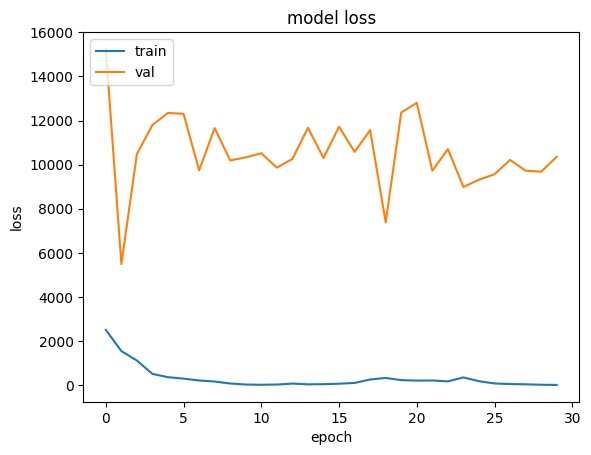

In [13]:
if __name__ == "__main__":
    print('vowlr')
    tf.keras.backend.clear_session()

    model1path = './drive/MyDrive/models/'

    #model1 = build_model1(model1path)
    #generate_pred_model1(model1)

    #model = build_model(True)
    #model.load_weights('macbeth.hdf5')
    #history = train_model(model)
    #loss_plot(history)

    mode = build_model(True)
    his = train_model(mode)
    loss_plot(his)

In [14]:
if __name__ == "__main__":
  print('vowlr')
  tf.keras.backend.clear_session()

  model = build_model(True)
  model.load_weights('macbeth.hdf5')

  x = reformat_mask_for_pred('./test_masks/coloa.png')
  #print(x)
  y = model.predict(x)
  print(y[0])

vowlr
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1022, 1022, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 511, 511, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 509, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 254, 254, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 4064256)      

In [ ]:
from google.colab import files
files.download("./macbeth.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model 1 - Do not run

In [ ]:
import shutil
shutil.copy("./drive/MyDrive/models/best-model.pth", "./models/best-model.pth")

'./models/best-model.pth'

In [ ]:
from fastai.vision.all import *

In [ ]:
def build_model1(model_path):
  from tqdm import tqdm
  import pathlib
  plt = platform.system()
  print(plt)
  if plt == 'Linux': pathlib.WindowsPath = pathlib.PosixPath
  torch.cuda.empty_cache()

  #model = unet_learner(arch=xresnet34)
  model = load_learner(model_path+r'berlin3.pkl', cpu=False)
  model.load('best-model')
  return model

SyntaxError: import * only allowed at module level (<ipython-input-11-f3d0743f2f33>, line 2)

In [ ]:
from PIL import Image

def generate_pred_model1(model):
  pics = os.listdir(r'./earth/')
  for img in pics:
    torch.cuda.empty_cache()
    im = Image.open(r'./earth/'+img)
    im.thumbnail((3000, 3000), Image.Resampling.LANCZOS)
    m = model.predict(im)
    m = to_image(m[2][1].repeat(3,1,1))
    pathsave = r'./earth_pics/'+img
    m.save(pathsave, "JPEG")

In [ ]:
def get_image_tiles_NEW2(path:Path) -> L:
   files = L()
   files = get_image_files(path=path, folders='im_tiles_ds2')
   return files

def get_y_fn_NEW2(fn:Path) -> str:
  #print(str(fn).replace('im_tiles', 'gt_tiles'))
  return str(fn).replace('im_tiles', 'gt_tiles')

def get_y_NEW2(fn:Path) -> PILMask:
   fn = get_y_fn_NEW2(fn)
   msk = np.array(PILMask.create(fn))
   #print(msk)
   #msk[msk==255] = 1
   msk = msk / 255
   #print(msk)
   return PILMask.create(msk)

In [ ]:
!zip -r './file.zip' './earth_pics/'

  adding: earth_pics/ (stored 0%)
  adding: earth_pics/hanoi_conhue.jpg (deflated 9%)
  adding: earth_pics/hanoi_cuanam.jpg (deflated 1%)
  adding: earth_pics/hcm_tanphu.jpg (deflated 2%)
  adding: earth_pics/hanoi_socson.jpg (deflated 8%)
  adding: earth_pics/hanoi_tulien.jpg (deflated 4%)
  adding: earth_pics/hanoi_minhkhai.jpg (deflated 0%)
  adding: earth_pics/hcm_govap.jpg (deflated 0%)
  adding: earth_pics/phuquoc_nam.jpg (deflated 9%)
  adding: earth_pics/quangninh_uongbi.jpg (deflated 2%)
  adding: earth_pics/hanoi_quangan.jpg (deflated 16%)
  adding: earth_pics/hanoi_caugiay.jpg (deflated 1%)
  adding: earth_pics/hanoi_vandien.jpg (deflated 2%)
  adding: earth_pics/hcm_q10.jpg (deflated 0%)
  adding: earth_pics/hanoi_tayho.jpg (deflated 6%)
  adding: earth_pics/hanoi_ngoclam.jpg (deflated 1%)
  adding: earth_pics/hanoi_quocoai.jpg (deflated 4%)
  adding: earth_pics/danang.jpg (deflated 0%)
  adding: earth_pics/baria.jpg (deflated 1%)
  adding: earth_pics/halong.jpg (deflated 5